### 0. Import libraries & functions

In [2]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0";
#from pudb import set_trace
import numpy as np
import torch
from torchvision import models

import torch.backends.cudnn as cudnn
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from utils_rb import *
from ramboattack import RamBoAtt
from HSJA_rb import HSJA
from SignOPT_rb import OPT_attack_sign_SGD

action = -1

import torch.nn as nn

# 定义Net类 (定义网络)

N_ACTIONS = 2               
N_STATES = 20

BATCH_SIZE = 32                                 # 样本数量
LR = 0.01                                       # 学习率
EPSILON = 0.99                                   # greedy policy
GAMMA = 0.9                                     # reward discount
TARGET_REPLACE_ITER = 100                       # 目标网络更新频率
MEMORY_CAPACITY = 2000                          # 记忆库容量

class Net(nn.Module):
    def __init__(self):                                                         # 定义Net的一系列属性
        # nn.Module的子类函数必须在构造函数中执行父类的构造函数
        super(Net, self).__init__()                                             # 等价与nn.Module.__init__()

        self.fc1 = nn.Linear(N_STATES, 50)                                      # 设置第一个全连接层(输入层到隐藏层): 状态数个神经元到50个神经元
        self.fc1.weight.data.normal_(0, 0.1)                                    # 权重初始化 (均值为0，方差为0.1的正态分布)
        self.out = nn.Linear(50, N_ACTIONS)                                     # 设置第二个全连接层(隐藏层到输出层): 50个神经元到动作数个神经元
        self.out.weight.data.normal_(0, 0.1)                                    # 权重初始化 (均值为0，方差为0.1的正态分布)

    def forward(self, x):                                                       # 定义forward函数 (x为状态)
        x = F.relu(self.fc1(x))                                                 # 连接输入层到隐藏层，且使用激励函数ReLU来处理经过隐藏层后的值
        actions_value = self.out(x)                                             # 连接隐藏层到输出层，获得最终的输出值 (即动作值)
        return actions_value 
    
class DQN(object):
    def __init__(self):                                                         # 定义DQN的一系列属性
        self.eval_net, self.target_net = Net(), Net()                           # 利用Net创建两个神经网络:评估网络和目标网络
        self.learn_step_counter = 0                                             # for target updating
        self.memory_counter = 0                                                 # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 +2 ))             # 初始化记忆库，一行代表一个transition
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)    # 使用Adam优化器(输入为评估网络的参数和学习率)
        self.loss_func = nn.MSELoss()                                           # 使用均方损失函数 (loss(xi, yi)=(xi-yi)^2)

    def choose_action(self, x):                                                 # 定义动作选择函数 (x为状态)
        x = torch.unsqueeze(torch.FloatTensor(x), 0)                            # 将x转换成32-bit floating point形式，并在dim=0增加维数为1的维度
        if np.random.uniform() < EPSILON:                                       # 生成一个在[0, 1)内的随机数，如果小于EPSILON，选择最优动作
            actions_value = self.eval_net.forward(x)                            # 通过对评估网络输入状态x，前向传播获得动作值
            action = torch.max(actions_value, 1)[1].data.numpy()                # 输出每一行最大值的索引，并转化为numpy ndarray形式
            action = action[0]                                                  # 输出action的第一个数
        else:                                                                   # 随机选择动作
            action = np.random.randint(0, N_ACTIONS)                            # 这里action随机等于0或1 (N_ACTIONS = 2)
        return action                                                           # 返回选择的动作 (0或1)

    def store_transition(self, s, a, r, s_):                                    # 定义记忆存储函数 (这里输入为一个transition)
        transition = np.hstack((s, [a, r], s_))                                 # 在水平方向上拼接数组
        # 如果记忆库满了，便覆盖旧的数据
        index = self.memory_counter % MEMORY_CAPACITY                           # 获取transition要置入的行数
        self.memory[index, :] = transition                                      # 置入transition
        self.memory_counter += 1                                                # memory_counter自加1

    def learn(self):                                                            # 定义学习函数(记忆库已满后便开始学习)
        # 目标网络参数更新
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:                  # 一开始触发，然后每100步触发
            self.target_net.load_state_dict(self.eval_net.state_dict())         # 将评估网络的参数赋给目标网络
        self.learn_step_counter += 1                                            # 学习步数自加1

        # 抽取记忆库中的批数据
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)            # 在[0, 2000)内随机抽取32个数，可能会重复
        b_memory = self.memory[sample_index, :]                                 # 抽取32个索引对应的32个transition，存入b_memory
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        # 将32个s抽出，转为32-bit floating point形式，并存储到b_s中，b_s为32行4列
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        # 将32个a抽出，转为64-bit integer (signed)形式，并存储到b_a中 (之所以为LongTensor类型，是为了方便后面torch.gather的使用)，b_a为32行1列
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        # 将32个r抽出，转为32-bit floating point形式，并存储到b_s中，b_r为32行1列
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])
        # 将32个s_抽出，转为32-bit floating point形式，并存储到b_s中，b_s_为32行4列

        # 获取32个transition的评估值和目标值，并利用损失函数和优化器进行评估网络参数更新
        q_eval = self.eval_net(b_s).gather(1, b_a)
        # eval_net(b_s)通过评估网络输出32行每个b_s对应的一系列动作值，然后.gather(1, b_a)代表对每行对应索引b_a的Q值提取进行聚合
        q_next = self.target_net(b_s_).detach()
        # q_next不进行反向传递误差，所以detach；q_next表示通过目标网络输出32行每个b_s_对应的一系列动作值
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
        # q_next.max(1)[0]表示只返回每一行的最大值，不返回索引(长度为32的一维张量)；.view()表示把前面所得到的一维张量变成(BATCH_SIZE, 1)的形状；最终通过公式得到目标值
        loss = self.loss_func(q_eval, q_target)
        # 输入32个评估值和32个目标值，使用均方损失函数
        self.optimizer.zero_grad()                                      # 清空上一步的残余更新参数值
        loss.backward()                                                 # 误差反向传播, 计算参数更新值
        self.optimizer.step()
        

In [3]:
def imshow(img):
    
    npimg = img[0].cpu().numpy()
    npimg = np.transpose(npimg,(1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.show()

In [4]:
def perturbation_heat_map(xo,xa):
    
    fig_dims = (5, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    x=torch.abs(xo-xa).sum(dim=1).cpu()[0]
    sns.heatmap(x,ax=ax,xticklabels=False, yticklabels=False,cbar = False)
    plt.show()

### 1. Load data, pretrained model, evaluation set

In [5]:
# a. Load dataset

batch_size = 32
dataset = 'cifar10' 
datapath = '../datasets/cifar10'
testloader, testset = load_data(dataset,data_path=datapath,batch_size=batch_size)

Files already downloaded and verified


In [6]:
# b. Load pre-trained model

# 'resnet50' if pre-trained model from Pytorch. 'cifar10' if using pre-trained cifar10 model
arch = 'cifar10' 

# None means using pre-traineded model from Pytorch or default path. Otherwise, please change model_path = '...'
model_path = None 

# True means pre-trained model does "not" normalized data while training, 
# so no need to unnorm during intergerence (used for CIFAR10 model)

if dataset == 'cifar10':
    num_classes = 10
    unnorm = True # True means pre-trained model does "not" normalized data while training.
    
net = load_model(arch,model_path)
model_rb = PretrainedModel(net,dataset,unnorm)

bounds = [0,1]
model_ex = PytorchModel_ex(net, bounds, num_classes,dataset,unnorm)

In [7]:
# c. Load evaluation set
targeted = True # True means targeted attack. False means untargeted attack.
# 'balance', 'easyset'->imagenet or cifar10; 
# 'hardset'-> imagenet; 
# 'hardset_A','hardset_B','hardset_D' -> cifar10
eval_set =  'hardset_A'

ID_set = get_evalset(dataset,targeted,eval_set)

### 2. HopSkipJump Evaluation

In [8]:
dqn=DQN()

i = 2 #0,1,2,10,20, 50,123 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,1] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

# 1. select starting image
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
    y_targ = np.array([tlabel])
else:
    tlabel = None
    y_targ = np.array([olabel])
    
# ============= 2. setup ==============
if dataset == 'cifar10':
    delta = 1e-2
    len_T = 500

constraint='l2'
num_iterations=150
gamma=1.0
stepsize_search='geometric_progression'
max_num_evals = 1e4
init_num_evals=100
verbose=True
auto_terminate=False

#seed = 0
#np.random.seed(seed)

In [9]:
model_ex = PytorchModel_ex(net, bounds, num_classes,dataset,unnorm)
module = HSJA(model_ex,constraint,num_iterations,gamma,stepsize_search,max_num_evals,init_num_evals, verbose,delta,len_T)
if targeted:
    adv, nqry, Dt = module.hsja(oimg.cpu().numpy(), y_targ, timg.cpu().numpy(),targeted,query_limit,auto_terminate)
else:
    timg = None
    adv, nqry, Dt = module.hsja(oimg.cpu().numpy(), y_targ, timg,targeted,auto_terminate)
    
adv = torch.unsqueeze(torch.from_numpy(adv).float(), 0).cuda()

iteration: 1, l2 distance 1.2249E+01 - nqry:140
iteration: 11, l2 distance 4.4887E+00 - nqry:2806
iteration: 21, l2 distance 2.4832E+00 - nqry:7040
iteration: 31, l2 distance 2.0693E+00 - nqry:12368
iteration: 41, l2 distance 1.6689E+00 - nqry:18592
iteration: 51, l2 distance 1.5403E+00 - nqry:25596
iteration: 61, l2 distance 1.4060E+00 - nqry:33300
iteration: 71, l2 distance 1.3204E+00 - nqry:41643
iteration: 81, l2 distance 1.2534E+00 - nqry:50579

Break due to over query limit!



Source image:


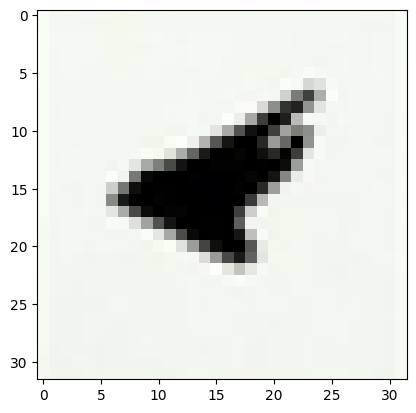

Starting image:


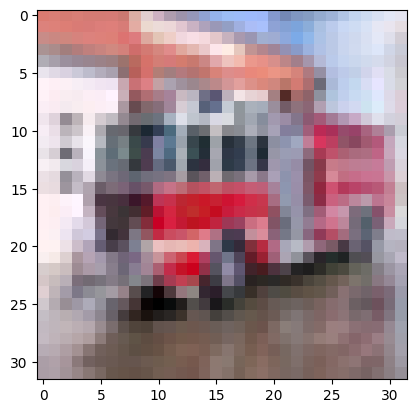

Adversarial Example:


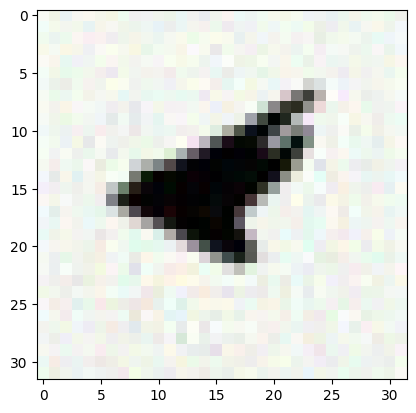

NameError: name 'Image' is not defined

In [10]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

def save_img(img, filename):
    npimg = img[0].cpu().numpy()
    npimg = np.transpose(npimg,(1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    pil_img = Image.fromarray(np.uint8(npimg*255))
    pil_img.save(filename)
save_img(adv,'adv.jpg')
imshow(adv)    
print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [ ]:
DHsja = Dt

### 3. Sign-OPT Evaluation

In [ ]:
i = 50#0,1,2,10,20,50,123 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,1] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

# 1. select starting image
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
    y_targ = np.array([tlabel])
else:
    tlabel = None
    y_targ = np.array([olabel])
    
# ============= 2. setup ==============
alpha = 0.2
beta = 0.001
iterations = 5000
distortion = None
stopping = 0.0001
auto_terminate=False
k=200

seed = 0
#np.random.seed(seed)

if dataset == 'cifar10':
    delta = 1e-2
    len_T = 2
elif dataset == 'imagenet':
    delta = 1
    len_T = 4

module = OPT_attack_sign_SGD(model_rb,k,delta,len_T,testset)

In [ ]:
if targeted:
    adv, nqry, Dt = module.attack_targeted(oimg, olabel, timg, tlabel, alpha, beta, iterations, query_limit, distortion, seed, stopping, auto_terminate)

In [ ]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [ ]:
DSopt = Dt

### 4. RamBoAttack Evaluation

### 4a. RamBoAttack (HSJA) Evaluation

In [ ]:
i = 1#0,1,2,10,20,50,123 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,1] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

# 1. select starting image
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
else:
    tlabel = None

In [ ]:
attack_mode = 'RBH' # 'RBH' means RamBoAttack(HSJA) while 'RBS' means RamBoAttack(Sign-OPT) -> see our paper
seed = 0
query_limit = 50000

model_ex = PytorchModel_ex(net, bounds, num_classes,dataset,unnorm)
module = RamBoAtt(model_rb,model_ex,testset,seed,targeted,dataset)
adv, nqry, Dt = module.hybrid_attack(oimg,olabel,timg,tlabel,query_limit,attack_mode)

In [ ]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [ ]:
DRambH = Dt

In [ ]:
# check prediction of adversarial example
alabel = model_rb.predict_label(adv).item()
dist = torch.norm(adv-oimg)
print(f'- sample ID: {o}\n- ground-truth: {olabel} \n- target label: {tlabel} \n- AdvEx label: {alabel}\n- L2 dist:{dist}')

In [ ]:

# successful_attacks = 0 # count the number of successful attacks
# for _ in range(100): # run the attack 100 times
#     i = 2 # 0,1,2,10,20,50,123: the sample i-th in the evaluation set
#     # Define the list of options
#     options = [0, 1, 2, 10, 20, 50, 123]

#     # Choose a random value from the list
#     i = random.choice(options)
#     query_limit = 5000
#     D = np.zeros(query_limit+2000)
#     nquery = 0
#     o = ID_set[i,1] # oID
#     # 0. select original image
#     oimg, olabel = testset[o]
#     oimg = torch.unsqueeze(oimg, 0).cuda()

#     # 1. select starting image
#     if targeted:
#         x = random.randint(1, 4)
#         y =random.randint(1,4)
#         t = ID_set[i,3] # tID, 3 is index across dataset - 4 is sample index in a class (not across dataset)
#         tlabel = ID_set[i,2]
#         timg, _ = testset[t]
#         timg = torch.unsqueeze(timg, 0).cuda()
#     else:
#         tlabel = None
#     attack_mode = 'RBS' # 'RBH' means RamBoAttack(HSJA) while 'RBS' means RamBoAttack(Sign-OPT) -> see our paper
#     seed = 0
#     query_limit = 1000
#     module = RamBoAtt(model_rb, model_ex, testset, seed, targeted, dataset)
#     adv, nqry, Dt = module.hybrid_attack(oimg, olabel, timg, tlabel, query_limit, attack_mode)
#     print(nqry)
#     if nqry > 1050: # check if the attack succeeded with more than 1000 queries
#         successful_attacks += 1

# print("Number of successful attacks with more than 1000 queries:", successful_attacks)

### 4b. RamBoAttack (SignOPT) Evaluation

In [ ]:
i = 50#0,1,2,10,20,50,123 # the sample i-th in the evaluation set
query_limit = 50000
D = np.zeros(query_limit+2000)
nquery = 0
o = ID_set[i,3] #oID

# 0. select original image
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()
print(ID_set[20,1])
imshow(oimg)
# 1. select starting image
if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    tlabel = ID_set[i,2]
    timg, _ = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
else:
    tlabel = None

In [ ]:
attack_mode = 'RBS' # 'RBH' means RamBoAttack(HSJA) while 'RBS' means RamBoAttack(Sign-OPT) -> see our paper
seed = 0
query_limit = 1000
module = RamBoAtt(model_rb,model_ex,testset,seed,targeted,dataset)
adv, nqry, Dt = module.hybrid_attack(oimg,olabel,timg,tlabel,query_limit,attack_mode)

In [ ]:
from PIL import Image
from skimage.io import imsave
import numpy as np
def save_img(img, filename):
    npimg = img[0].cpu().numpy()
    npimg = np.transpose(npimg,(1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    pil_img = Image.fromarray(np.uint8(npimg*255))
    pil_img.save(filename)
    
print('Source image:')
imshow(oimg)
#oimg.save('Source_image.jpg')
print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
save_img(adv,'adv.jpg')
#oimg.save('Adversarial Example.jpg')
print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [ ]:
DRambS = Dt

In [ ]:
# check prediction of adversarial example
alabel = model_rb.predict_label(adv).item()
dist = torch.norm(adv-oimg)
print(f'- sample ID: {o}\n- ground-truth: {olabel} \n- target label: {tlabel} \n- AdvEx label: {alabel}\n- L2 dist:{dist}')

### 6. Plot Distortion vs Queries

In [ ]:
nq = query_limit
q = np.arange(nq)
df = pd.DataFrame({'qry':q,'dRambH':np.log(DRambH[:query_limit]),
                   'dRambS':np.log(DRambS[:query_limit]),
                   'dHsja':np.log(DHsja[:query_limit]),
                  'dSopt':np.log(DSopt[:query_limit])})

fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
f = sns.lineplot(x = 'qry', y = 'dRambH',ax=ax,linewidth = 3, color = 'red',label = 'RamBoAttack (HSJA)',data=df)
f = sns.lineplot(x = 'qry', y = 'dRambS',ax=ax,linewidth = 3, color = 'blue',label = 'RamBoAttack (SOPT)',data=df)
f = sns.lineplot(x = 'qry', y = 'dHsja',ax=ax,linewidth = 3, color = 'green',label = 'HopSkipJump',data=df)
f = sns.lineplot(x = 'qry', y = 'dSopt',ax=ax,linewidth = 3, color = 'orange',label = 'Sign-OPT',data=df)

f.axes.set_title("Distortion vs Queries (RamBoAttack)",fontsize=20)
f.set_xlabel("Queries",fontsize=18)
f.set_ylabel("Log10 (L2 dist)",fontsize=18)
f.tick_params(labelsize=15)
#plt.legend(labels=['RamBoAttack (HSJA)'])
plt.legend(title='Attack', fontsize='14', title_fontsize='18',bbox_to_anchor= (1.5,1))
plt.show()